In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import random
import numpy as np
from qpthlocal.qp import QPFunction
from qpthlocal.qp import QPSolvers
from qpthlocal.qp import make_gurobi_model
import pickle
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
def make_matching_matrix(n):
    
    # n is num elements?
    lhs = list(range(n))
    rhs = list(range(n, 2*n))
    
    # n_vars is 1 per possible edge?
    n_vars = len(lhs)*len(rhs)
    # n_constraints is 1 for each lhs, 1 for each rhs, 1 per edge?
    n_constraints = len(lhs) + len(rhs) + n_vars
    A = np.zeros((n_constraints, n_vars))
    b = np.zeros((n_constraints))
    curr_idx = 0
    edge_idx = {}
    # get an index per edge
    for u in lhs:
        for v in rhs:
            edge_idx[(u,v)] = curr_idx
            curr_idx += 1
    # A has rows of 2n elements, followed by n^2 edges
    # A has cols of n^2 edges (so A @ x where x is edges)
    for u in lhs:
        for v in rhs:
            # for u, flip on coefficient for only its outgoing edges
            A[u, edge_idx[(u,v)]] = 1
            # for v, flip on coefficient for only its incoming edges
            A[v, edge_idx[(u,v)]] = 1
            # for the edge itself, flip on a single -1 at its point only
            A[len(lhs)+len(rhs)+edge_idx[(u,v)], edge_idx[(u,v)]] = -1
    
    # each element can have only 1 edge turned on in x
    for u in lhs:
        b[u] = 1
    for u in rhs:
        b[u] = 1
    
    
    return A, b


In [3]:
A, b = make_matching_matrix(10)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))


Academic license - for non-commercial use only


In [4]:
c_rand = -torch.rand(100, requires_grad=True)

In [5]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)

In [6]:
# Q is gamma * I
# we're not batching

match = func(gamma*torch.eye(A.shape[1]), c_rand, A, b, torch.Tensor(), torch.Tensor())

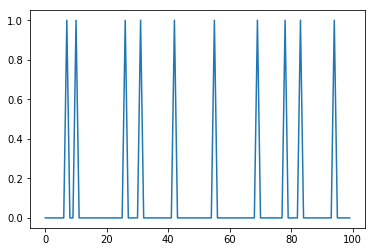

In [7]:
plt.plot(match.detach().numpy().flatten())

In [8]:
match.sum().backward()

## plan for dynamic setting:
- d types
- pool of elements curr_elem each with type (n at each time step)
- known edge weights between each type (?) e_weight (size n^2, recomputed at each time step)
- learned_coeff weights modify known edge weights (weights for each type, effectively pair of types, so d of these)
- perform match, true value of match is e_weight * x
- remove elements, recreate curr_elem, recreate e_weight

some thoughts: encoding type of pool of elements should be either LongTensor or one-hot so can get gradients after indexing



In [9]:
d=10
rand_d_weights = torch.rand(d, requires_grad=True)

In [10]:
n = 20
rand_types_pool = torch.randint(d,(n,))

In [11]:
curr_weights = rand_d_weights[rand_types_pool]

In [12]:
rand_e_weight = torch.rand(n,n) # in reality should be based on types (but not on weights)

In [13]:
modified_edge_weights = rand_e_weight + 0.5*(torch.unsqueeze(curr_weights,0) + torch.unsqueeze(curr_weights, 1))

In [14]:
A, b = make_matching_matrix(n)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.0001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))

In [15]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params = model_params_quad)

In [16]:
resulting_match = func(gamma*torch.eye(A.shape[1]), -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(20,20)

In [17]:
modified_edge_weights

tensor([[1.0088, 0.5033, 1.2707, 0.6555, 1.2277, 0.5419, 0.8785, 1.0661, 0.5055,
         0.5260, 1.2953, 0.8800, 0.6355, 1.2751, 1.1322, 0.7010, 1.2724, 1.1152,
         0.5850, 1.2733],
        [0.7345, 0.3789, 1.2510, 1.4393, 1.4939, 0.6846, 0.8518, 1.0401, 0.7943,
         1.1400, 1.3639, 0.7931, 1.1558, 0.6792, 1.4045, 1.3271, 0.3828, 0.5607,
         0.6380, 0.5357],
        [0.7101, 1.1220, 1.4005, 1.3227, 1.6695, 0.7999, 0.5881, 0.6194, 0.5002,
         0.9990, 0.9013, 1.4565, 1.2269, 0.6959, 0.7814, 1.0385, 1.0641, 0.4557,
         1.4060, 1.2536],
        [1.1576, 1.2476, 1.4076, 1.2014, 0.9687, 1.2802, 1.6432, 0.9330, 0.9339,
         1.1739, 1.2075, 0.7469, 1.5391, 1.4376, 1.6369, 1.4834, 1.3859, 0.5562,
         1.6778, 1.5626],
        [1.3931, 1.4465, 0.8822, 1.2957, 1.3464, 1.3946, 1.1231, 1.1700, 1.2848,
         0.9567, 1.1326, 1.1568, 0.9697, 1.3881, 0.7585, 1.4687, 1.1809, 1.1645,
         0.8788, 0.7658],
        [1.2316, 0.4184, 0.8966, 1.5160, 1.0595, 0.9909, 0.7

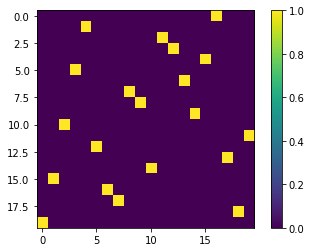

In [18]:
plt.imshow(resulting_match.detach().numpy())
plt.colorbar()

In [19]:
true_cost = torch.sum(resulting_match * rand_e_weight)

In [20]:
true_cost

tensor(18.8701, grad_fn=<SumBackward0>)

next step: decide on arrival/departure model -- presumably it should be type-dependent (one rare type with one really good edge to one other type)

In [21]:
type_arrival_rates = torch.rand(d)
type_departure_probs = torch.rand(d)

In [22]:
torch.max(resulting_match, 0).values != 1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8)

In [23]:
new_match = resulting_match.clone()

In [24]:
new_match[19,15] = 0.0

In [25]:
new_match[16,0] = 0.0

In [26]:
torch.poisson(type_arrival_rates)

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])

In [27]:
def ind_counts_to_longs(arrival_counts):
    # optimize later
    results = []
    for i in range(arrival_counts.shape[0]):
        for j in range(arrival_counts[i].long().item()):
            results.append(i)
    return torch.LongTensor(results)

In [28]:
ind_counts_to_longs(torch.poisson(type_arrival_rates))

tensor([7, 8])

In [53]:
def step_simulation(current_elems, match_edges, type_arrival_rates, type_departure_probs, match_thresh=0.8):
    # first match elements
    pool_after_match = current_elems[torch.max(match_edges, 0).values <= match_thresh]
    
    # now handle departures
    if pool_after_match.shape[0] > 0:
        remaining_elements_depart_prob = type_departure_probs[pool_after_match]
        remain = torch.bernoulli(1 - remaining_elements_depart_prob).nonzero().view(-1)
        remaining_elements = pool_after_match[remain]
    else:
        remaining_elements = pool_after_match
    
    # now get new elements (poisson?)
    after_arrivals = torch.cat((remaining_elements, ind_counts_to_longs(torch.poisson(type_arrival_rates))))
    
    return after_arrivals

In [54]:
step_simulation(rand_types_pool, new_match, type_arrival_rates, type_departure_probs)

tensor([0, 1, 2, 2, 2, 2, 4, 5, 5, 8])

In [31]:
type_departure_probs[9] = 0.1

In [32]:
def edge_matrix(current_elems, e_weights_by_type):
    # compute the matrix of edge weights by type of each element
    # should actually be shaped as matrix, will be flattened later
    
    # optimize later
    edge_mat = torch.zeros((current_elems.shape[0], current_elems.shape[0]))
    for i in range(current_elems.shape[0]):
        for j in range(current_elems.shape[0]):
            u = current_elems[i]
            v = current_elems[j]
            edge_mat[i, j] = e_weights_by_type[u, v]
            
    return edge_mat

In [33]:
xx = torch.rand((d,d))
e_weights_by_type_rand = (xx + xx.t())

In [34]:
edge_matrix(rand_types_pool, e_weights_by_type_rand)

tensor([[0.7397, 0.8554, 1.2337, 0.7997, 0.7321, 1.4871, 1.0507, 1.4871, 1.4871,
         1.0507, 0.7997, 0.8554, 0.7397, 1.4871, 1.0507, 0.8554, 0.8554, 1.2390,
         1.2337, 0.7321],
        [0.8554, 0.4638, 0.4957, 0.9285, 0.8939, 0.7790, 1.3341, 0.7790, 0.7790,
         1.3341, 0.9285, 0.4638, 0.8554, 0.7790, 1.3341, 0.4638, 0.4638, 1.4925,
         0.4957, 0.8939],
        [1.2337, 0.4957, 0.2027, 0.7453, 1.0799, 1.0757, 0.9764, 1.0757, 1.0757,
         0.9764, 0.7453, 0.4957, 1.2337, 1.0757, 0.9764, 0.4957, 0.4957, 1.1184,
         0.2027, 1.0799],
        [0.7997, 0.9285, 0.7453, 0.3107, 0.6095, 1.8946, 0.9017, 1.8946, 1.8946,
         0.9017, 0.3107, 0.9285, 0.7997, 1.8946, 0.9017, 0.9285, 0.9285, 1.6139,
         0.7453, 0.6095],
        [0.7321, 0.8939, 1.0799, 0.6095, 0.3429, 0.8375, 0.7919, 0.8375, 0.8375,
         0.7919, 0.6095, 0.8939, 0.7321, 0.8375, 0.7919, 0.8939, 0.8939, 0.9019,
         1.0799, 0.3429],
        [1.4871, 0.7790, 1.0757, 1.8946, 0.8375, 1.2590, 0.6

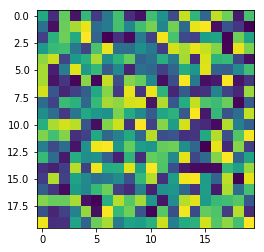

In [35]:
plt.imshow(rand_e_weight.numpy())

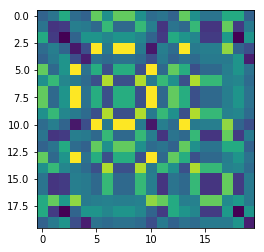

In [36]:
plt.imshow(edge_matrix(rand_types_pool, e_weights_by_type_rand).numpy())

In [42]:
e_weights_by_type_rand

tensor([[1.6902, 0.1952, 0.9446, 1.3341, 1.0847, 1.0507, 0.9764, 0.6180, 0.9017,
         0.7919],
        [0.1952, 1.4336, 1.2223, 1.0115, 1.3698, 0.6467, 0.9974, 0.9147, 1.6397,
         0.9531],
        [0.9446, 1.2223, 1.0116, 1.4925, 0.5199, 1.2390, 1.1184, 0.9239, 1.6139,
         0.9019],
        [1.3341, 1.0115, 1.4925, 0.4638, 1.3867, 0.8554, 0.4957, 0.7790, 0.9285,
         0.8939],
        [1.0847, 1.3698, 0.5199, 1.3867, 0.4670, 0.6373, 1.6869, 1.8842, 1.4406,
         0.5605],
        [1.0507, 0.6467, 1.2390, 0.8554, 0.6373, 0.7397, 1.2337, 1.4871, 0.7997,
         0.7321],
        [0.9764, 0.9974, 1.1184, 0.4957, 1.6869, 1.2337, 0.2027, 1.0757, 0.7453,
         1.0799],
        [0.6180, 0.9147, 0.9239, 0.7790, 1.8842, 1.4871, 1.0757, 1.2590, 1.8946,
         0.8375],
        [0.9017, 1.6397, 1.6139, 0.9285, 1.4406, 0.7997, 0.7453, 1.8946, 0.3107,
         0.6095],
        [0.7919, 0.9531, 0.9019, 0.8939, 0.5605, 0.7321, 1.0799, 0.8375, 0.6095,
         0.3429]])

In [37]:
# type_weights is the learned parameter

def compute_matching(current_elems, curr_type_weights, e_weights_by_type, gamma=0.00001):
    n = current_elems.shape[0]
    A, b = make_matching_matrix(n)
    A = torch.from_numpy(A).float()
    b = torch.from_numpy(b).float()
    # for some reason we need this randomness to end up with an actual matching
    e_weights = edge_matrix(current_elems, e_weights_by_type)
    jitter_e_weights = e_weights + 1e-4*torch.rand(n,n)
    #e_weights = torch.rand(n,n)
    model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))
    func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)
    
    Q_mat = gamma*torch.eye(A.shape[1])
    
    curr_elem_weights = curr_type_weights[current_elems]
    modified_edge_weights = jitter_e_weights + 0.5*(torch.unsqueeze(curr_elem_weights,0) + torch.unsqueeze(curr_elem_weights,1))
    # may need some negative signs
    resulting_match = func(Q_mat, -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(n,n)
    return resulting_match, e_weights

In [38]:
new_match, e_weights = compute_matching(rand_types_pool, rand_d_weights, e_weights_by_type_rand, gamma=1e-7)

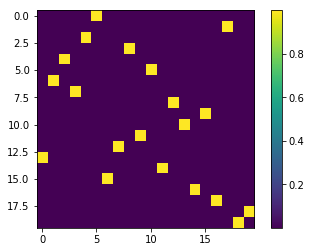

In [39]:
plt.imshow(new_match.detach().numpy())
plt.colorbar()

In [40]:
loss = torch.sum(new_match*e_weights)


In [41]:
loss.backward()

# a toy problem

- d=5 types
- type 0: arrives rarely, departs fast
- type 1,2,3,4 arrive and depart reasonably
- edge weights: 0-1 very good 10, 0-234 don't exist, all others 0.1 or whatever
- should learn some small weight not to match 1, hopefully

In [94]:
def toy_e_weights_type():
    mat = 0.1*torch.ones(5,5)
    mat[0,1] = 10.0
    mat[1,0] = 10.0
    mat[0,0] = 0.0
    mat[0,2:5] = 0.0
    mat[2:5,0] = 0.0
    return mat

toy_arrival_rates = torch.Tensor([0.1,1.0,1.0,1.0,1.0])
toy_departure_probs = torch.Tensor([0.9,0.1,0.1,0.1,0.1])

In [97]:
n_rounds = 10
n_epochs = 10
e_weights_type = toy_e_weights_type()
init_pool = torch.LongTensor([0,1,2,3,4])
type_weights = torch.ones(5, requires_grad=True)
optimizer = torch.optim.Adam([type_weights], lr=1e-1, weight_decay=1e-1)
for e in tqdm(range(n_epochs)):
    losses = []
    curr_pool = init_pool.clone()
    for r in range(n_rounds):
        resulting_match, e_weights = compute_matching(curr_pool, type_weights, e_weights_type)
        losses.append(-1.0*torch.sum(resulting_match * e_weights))
        curr_pool = step_simulation(curr_pool, resulting_match, toy_arrival_rates, toy_departure_probs)
    total_loss = torch.sum(torch.stack(losses))
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

In [98]:
type_weights

tensor([1.8126, 1.9092, 1.7740, 1.8224, 1.8476], requires_grad=True)